[Reference](https://towardsdatascience.com/time-series-transformations-selection-using-edaspy-d97e0dc1fcca)

In [2]:
pip install EDAspy

     |████████████████████████████████| 40kB 4.1MB/s 


In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# EDAspy libraries
from EDAspy.timeseries import EDA_ts_fts as EDA
from EDAspy.timeseries import TS_transformations

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
mdata = sm.datasets.macrodata.load_pandas().data
df = mdata.iloc[:, 2:12]
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop
0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146
1,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830
2,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657
3,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386
4,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007


In [5]:
variables = list(df.columns)
variable_y = 'pop'  # pop is the variable we want to forecast
variables = list(set(variables) - {variable_y})  # array of variables to select among transformations
variables

['unemp',
 'realgdp',
 'cpi',
 'tbilrate',
 'realinv',
 'realgovt',
 'realcons',
 'realdpi',
 'm1']

In [7]:
TSTransf = TS_transformations.TSTransformations(df)
transformations = ['detrend', 'smooth', 'log']  # postfix to variables, to denote the transformation

# build the transformations
for var in variables:
    transformation = TSTransf.de_trending(var)
    df[var + 'detrend'] = transformation

for var in variables:
    transformation = TSTransf.smoothing(var, window=10)
    df[var + 'smooth'] = transformation

for var in variables:
    transformation = TSTransf.log(var)
    df[var + 'log'] = transformation

In [8]:
def cost_function(variables_list, nobs=20, maxlags=15, forecastings=10):
    """
    variables_list: list of variables without the variable_y
    nobs: how many observations for validation
    maxlags: previous lags used to predict
    forecasting: number of observations to predict
    
    return: MAE of the prediction with the real validation data
    """
    
    data = df[variables_list + [variable_y]]

    df_train, df_test = data[0:-nobs], data[-nobs:]

    model = VAR(df_train)
    results = model.fit(maxlags=maxlags, ic='aic')

    lag_order = results.k_ar
    array = results.forecast(df_train.values[-lag_order:], forecastings)

    variables_ = list(data.columns)
    position = variables_.index(variable_y)

    validation = [array[i][position] for i in range(len(array))]
    mae = mean_absolute_error(validation, df_test['pop'][-forecastings:])
    
    return mae

In [9]:
mae_pre_eda = cost_function(variables)
print('MAE without using EDA:', mae_pre_eda)

MAE without using EDA: 5.09147801001331


In [10]:
vector = pd.DataFrame(columns=list(variables))
vector.loc[0] = 0.5

In [11]:
eda = EDA(max_it=50, dead_it=5, size_gen=15, alpha=0.7, vector=vector,
          array_transformations=transformations, cost_function=cost_function)
best_ind, best_MAE = eda.run(output=True)

[iteration: 0 ] 4.582044935325411
[iteration: 1 ] 5.288557507894836
[iteration: 2 ] 5.2603328753027885
[iteration: 3 ] 5.297341789981158
[iteration: 4 ] 5.164647056379982


Solution: ['realgdpsmooth', 'cpilog', 'tbilratebasic', 'realinvlog', 'realgovtdetrend', 'realconsdetrend', 'realdpismooth', 'm1detrend'] 
MAE post EDA: 4.58 
MAE pre EDA: 5.09


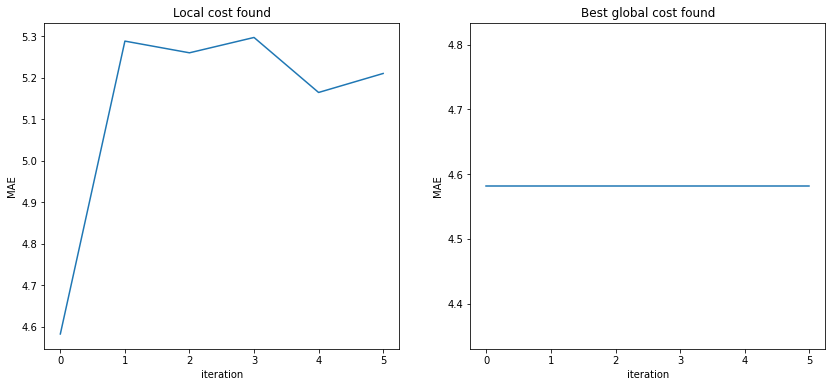

In [12]:
hist = eda.historic_best

relative_plot = []
mx = 999999999
for i in range(len(hist)):
    if hist[i] < mx:
        mx = hist[i]
        relative_plot.append(mx)
    else:
        relative_plot.append(mx)

print('Solution:', best_ind, '\nMAE post EDA: %.2f' % best_MAE, '\nMAE pre EDA: %.2f' % mae_pre_eda)

plt.figure(figsize = (14,6))

ax = plt.subplot(121)
ax.plot(list(range(len(hist))), hist)
ax.title.set_text('Local cost found')
ax.set_xlabel('iteration')
ax.set_ylabel('MAE')

ax = plt.subplot(122)
ax.plot(list(range(len(relative_plot))), relative_plot)
ax.title.set_text('Best global cost found')
ax.set_xlabel('iteration')
ax.set_ylabel('MAE')

plt.show()